# Text Analysis Spark

Date: 04/09/2019

Libraries used:

* re (for regular expression)
* nltk.corpus (for stop words)
* malplotlib.pyplot (for creating plots)
* pyspark (for using sparkCore)
* pyspark.sql (for utilising sparkSQL)


## 1. Introduction
This task of the notebook consist of using the power of spark RDDs (Resilient Distributed Dataset) to analyse text data that can be further supplied to machine learning algorithms.

More details for each task will be given in the following sections.

## Importing Libraries

In [1]:
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession 

## Step 1
Initializing Spark to run on the machine locally

In [2]:

sc = SparkContext.getOrCreate()
if (sc == None):
    sc = SparkContext(master = "local[*]",appName = "Assignment 1")
spark = SparkSession(sparkContext = sc)



## Step 2
Creating the RDDs using the 2 books that needs to be analysed and printing the number of lines in each book using the `count()`. 

Note : It counts the number of lines including `blank lines`

In [3]:
book_1 = sc.textFile("data/Agile Processes  in Software Engineering  and Extreme Programming.txt")
book_2 = sc.textFile("data/Scrum Handbook.txt")

In [4]:
print("Number of lines in Book 1 :",book_1.count())
print("Number of lines in Book 2 :",book_2.count())


Number of lines in Book 1 : 21569
Number of lines in Book 2 : 4617


## Step 3

Now that we have the data in the RDDs we start by `manipulating/cleaning` the data as raw data genrally can not be used for analysis of textual data.

The method below `non_alpha` is used to `Remove characters that are non alphabets`, except spaces. 

In [5]:
def non_alpha(string):
    reg_ex = r'[^A-Za-z\s]'
    return re.sub(reg_ex,'',string)

The method below is used to clean the data. It performs the following function:
* First it calls the non_alpha function to remove all the non alphabet characters excluding spaces
* Then it removes the extra spaces that might be there in the begining or end of each line
* Lastly, it converts each line to lower case 


In [6]:
def manipulate_RDD(book_rdd):
    book_rdd = book_rdd.map(non_alpha)
    book_rdd = book_rdd.map(lambda x: x.strip())
    book_rdd = book_rdd.map(lambda x: x.lower())
    return book_rdd

In [7]:
book_1 = manipulate_RDD(book_1)
book_2 = manipulate_RDD(book_2)

Displaying the content of the RDDs

In [8]:
print("Book 1 content = ", book_1.collect())
print("Book 2 content = ", book_2.collect())

Book 1 content =  ['lnbip', '', '', 'i helen sharp', '', 'tracy hall eds', '', 'agile processes', 'in software engineering', 'and extreme programming', '', 'th international conference xp', 'edinburgh uk may', 'proceedings', '', '', 'springer open', '', '', '', '', '', '', '', 'lecture notes', '', 'in business information processing', '', '', 'series editors', '', 'wil van der aalst', '', 'eindhoven technical university eindhoven the netherlands', 'john mylopoulos', '', 'university of trento povo italy', 'michael rosemann', '', 'queensland university of technology brisbane qld australia', 'michael j shaw', '', 'university of illinois urbanachampaign il usa', 'clemens szyperski', '', 'microsoft research redmond wa usa', '', '', '', 'more information about this series at httpwwwspringercomseries', '', '', '', 'helen sharp  tracy hall eds', '', '', 'agile processes', 'in software engineering', 'and extreme programming', '', 'th international conference xp', 'edinburgh uk may', 'proceeding

## Step 4
Now we split the string into individual words using the split function and create a new RDD with each row as (word,1) that can be later transformer (`reduceByKey`) to count the frequency of each word

In [9]:
book_1_words = book_1.flatMap(lambda x:x.split())
book_2_words = book_2.flatMap(lambda x:x.split())

In [10]:
book_1_wc = book_1_words.map(lambda x: (x,1)).reduceByKey(lambda x,y:x+y)
book_2_wc = book_2_words.map(lambda x: (x,1)).reduceByKey(lambda x,y:x+y)


The RDDs are sorted in decending order to get the most frequent words on the top

In [11]:
book_1_wc = book_1_wc.sortBy(lambda x: x[1], ascending = False)
book_2_wc = book_2_wc.sortBy(lambda x: x[1], ascending = False)

In [12]:
freq_b1 = book_1_wc.take(20)
freq_b2 = book_2_wc.take(20)

In [13]:
print("Book 1 most frequent words :\n",freq_b1)
print("\n\nBook 2 most frequent words :\n",freq_b2)

Book 1 most frequent words :
 [('the', 8145), ('and', 3965), ('of', 3944), ('to', 3714), ('in', 3076), ('a', 2701), ('is', 1539), ('that', 1355), ('for', 1194), ('as', 1028), ('on', 1015), ('we', 975), ('with', 969), ('software', 922), ('this', 915), ('are', 784), ('agile', 748), ('it', 741), ('development', 737), ('was', 711)]


Book 2 most frequent words :
 [('the', 1238), ('of', 537), ('and', 534), ('to', 477), ('a', 451), ('scrum', 395), ('in', 360), ('is', 348), ('team', 260), ('product', 232), ('for', 195), ('that', 181), ('it', 165), ('on', 149), ('sprint', 146), ('this', 142), ('with', 132), ('as', 124), ('are', 119), ('by', 118)]


## Step 5
Now we remove the stop words from each RDD as these words convey little meaning to the RDDs in term of analysis. After removing these stop words we count the number of unique words in each book and display it. 

In [14]:
stopwords = stopwords.words('english')

In [15]:
book_1_wc = book_1_wc.filter(lambda x : x[0] not in stopwords)
book_2_wc = book_2_wc.filter(lambda x : x[0] not in stopwords)


In [16]:
print("Number of Unique words in Book 1 : ",book_1_wc.count())
print("Number of Unique words in Book 2 : ",book_2_wc.count())

Number of Unique words in Book 1 :  9611
Number of Unique words in Book 2 :  2936


## Step 6

Here we find and display the average occurence of words in each dataset i.e each book.

In [17]:
total_wc_b1 = book_1_wc.map(lambda x: x[1]).sum()
total_wc_b2 = book_2_wc.map(lambda x: x[1]).sum()

In [18]:
avg_words_freq1 = total_wc_b1/book_1_wc.count()
avg_words_freq2 = total_wc_b2/book_2_wc.count()


In [19]:
print("Average word freqency in Book 1 : ",avg_words_freq1)
print("Average word freqency in Book 2 : ",avg_words_freq2)

Average word freqency in Book 1 :  8.225574862137135
Average word freqency in Book 2 :  3.681880108991826


Here we try to manipulate data for visualisation purpose, 
* we start by first finding just the unique words for each book
* then we find the works that are present in book one and not present in book 2
* we add these words to book 2 with a freqency of zero
* we repeat the same thing for the other book
* lastly we sort the RDD so that each word occur in same position in both RDDs

Note: We do so to get the same index for each word in both the RDDs

In [20]:
words_b1 = book_1_wc.map(lambda x: x[0])
words_b2 = book_2_wc.map(lambda x: x[0])

In [21]:
wordsB1_notB2 = words_b1.subtract(words_b2) # to be added in b2
wordsB2_notB1 = words_b2.subtract(words_b1) # to be added in b1

In [22]:
book_1_wc = book_1_wc.union(wordsB2_notB1.map(lambda x:(x,0)))
book_2_wc = book_2_wc.union(wordsB1_notB2.map(lambda x:(x,0)))

Here we create a dataframe that contains the frequency of words in each book. This dataframe makes the visualisation task very easy.

In [23]:
freq_dist = book_1_wc.join(book_2_wc)
freq_dist = freq_dist.map(lambda x: (x[0], x[1][0],x[1][1])).sortBy(lambda x: x[0])
freq_df = spark.createDataFrame(freq_dist,["word","Book1","Book2"])
freq_df.show()

+---------+-----+-----+
|     word|Book1|Book2|
+---------+-----+-----+
|       aa|    1|    0|
|      aaa|    0|    1|
|   aachen|    1|    0|
|    aalst|    1|    0|
|    aalto|    5|    0|
|   aarhus|    0|    1|
|       ab|    6|    1|
|  abandon|    3|    0|
|abandoned|    0|    1|
|      abc|    1|    0|
| aberdeen|    1|    0|
|abilities|   10|    0|
|  ability|   52|    0|
|     able|   58|    5|
|ableenjoy|    1|    0|
|     ably|    2|    0|
| abnormal|    1|    0|
|      abo|    1|    0|
|    abort|    0|    1|
|     abra|    1|    0|
+---------+-----+-----+
only showing top 20 rows



## Step 7
Now we try to visualise the data to get some insights

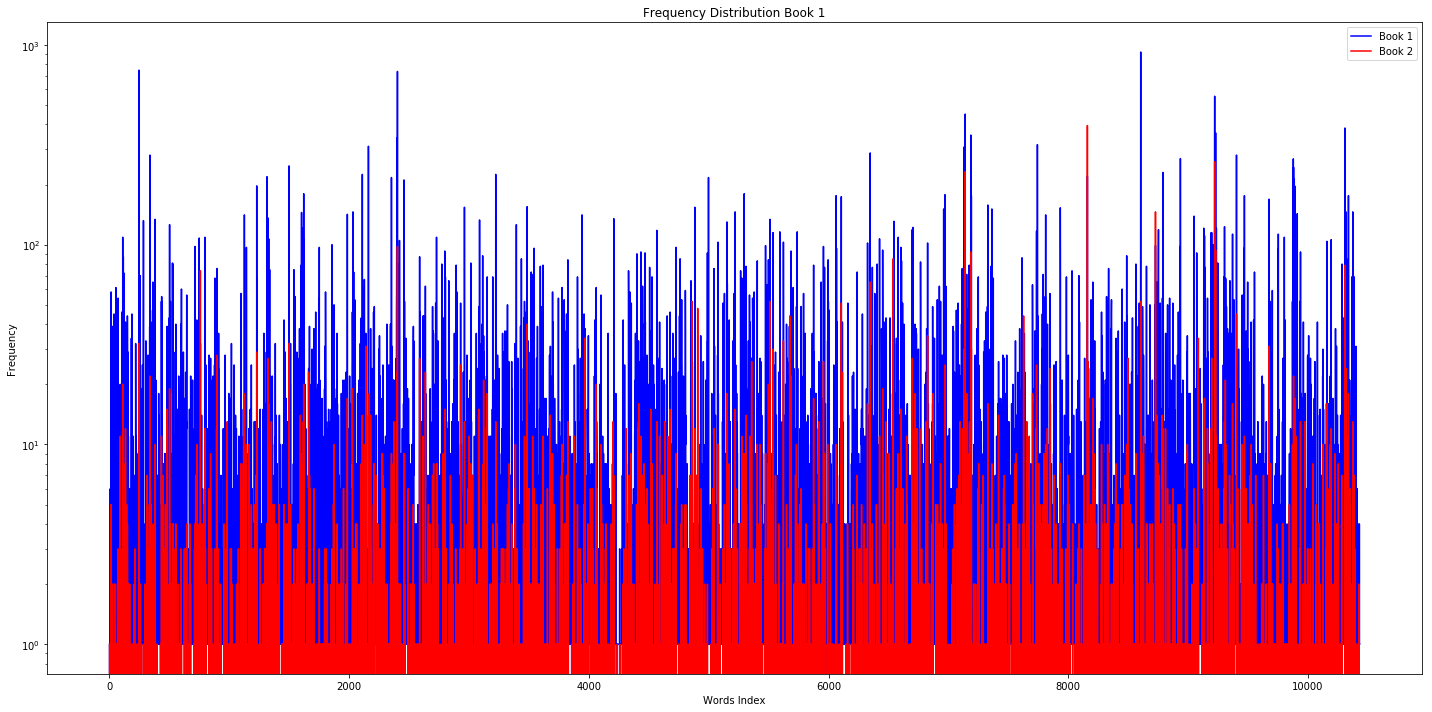

In [24]:
freq_B1_sort = freq_df.collect()
book_1_freq = [each_row['Book1'] for each_row in freq_B1_sort]
book_2_freq = [each_row['Book2'] for each_row in freq_B1_sort]
x_labels = list(range(1,10431))

fig,ax1 = plt.subplots(figsize = (20,10))
ax1.plot(x_labels,book_1_freq,label = 'Book 1',color = 'b')
ax1.plot(x_labels,book_2_freq,label = 'Book 2',color = 'r')
ax1.legend(loc = 'upper right')
ax1.set_xlabel('Words Index')
ax1.set_ylabel('Frequency')
ax1.set_title('Frequency Distribution Book 1')
ax1.set_yscale('log')


plt.tight_layout()
plt.show()


The graph above show the distribution of words in each document combined. Here we can see that the number of words occuring in Book 1 in `Blue` is more for almost all the words  as compared to the frequency in Book 2 in `Red`. 

To get more insigths we sort the dictionary with respect to freqency in Book 1 and then plot the results again using the `log scale`.

In [25]:
freq_B1_sort = freq_df.sort("Book1",ascending = False).collect()
book_1_freq = [each_row['Book1'] for each_row in freq_B1_sort]
book_2_freq = [each_row['Book2'] for each_row in freq_B1_sort]
x_labels = list(range(1,10431))

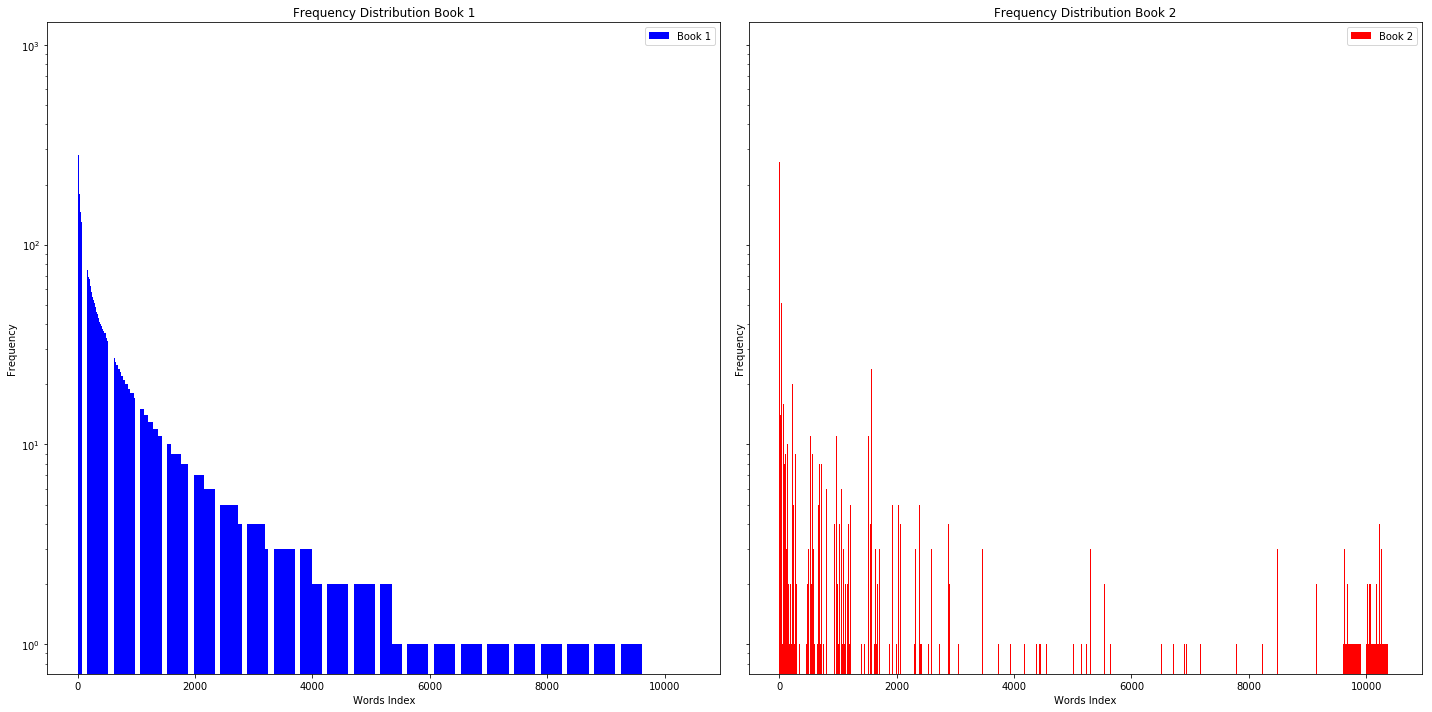

In [26]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,10),sharey = True,sharex=True)

ax1.bar(x_labels,book_1_freq,label = 'Book 1',color = 'b')
ax1.legend(loc = 'upper right')
ax1.set_xlabel('Words Index')
ax1.set_ylabel('Frequency')
ax1.set_title('Frequency Distribution Book 1')
ax1.set_yscale('log')

ax2.bar(x_labels,book_2_freq,label = 'Book 2',color = 'r')
ax2.legend(loc = 'upper right')
ax2.set_xlabel('Words Index')
ax2.set_ylabel('Frequency')
ax2.set_title('Frequency Distribution Book 2')

plt.tight_layout()
plt.show()

We can see from the graph above that the overall pattern in both the plots are same i.e decreasing from left to right. This helps us understand that the words that are used more in book 1 are also used more in book 2 and vise-versa. 

We can try to combine the results of the above plots to showcase our finding. We do so in the plot below.

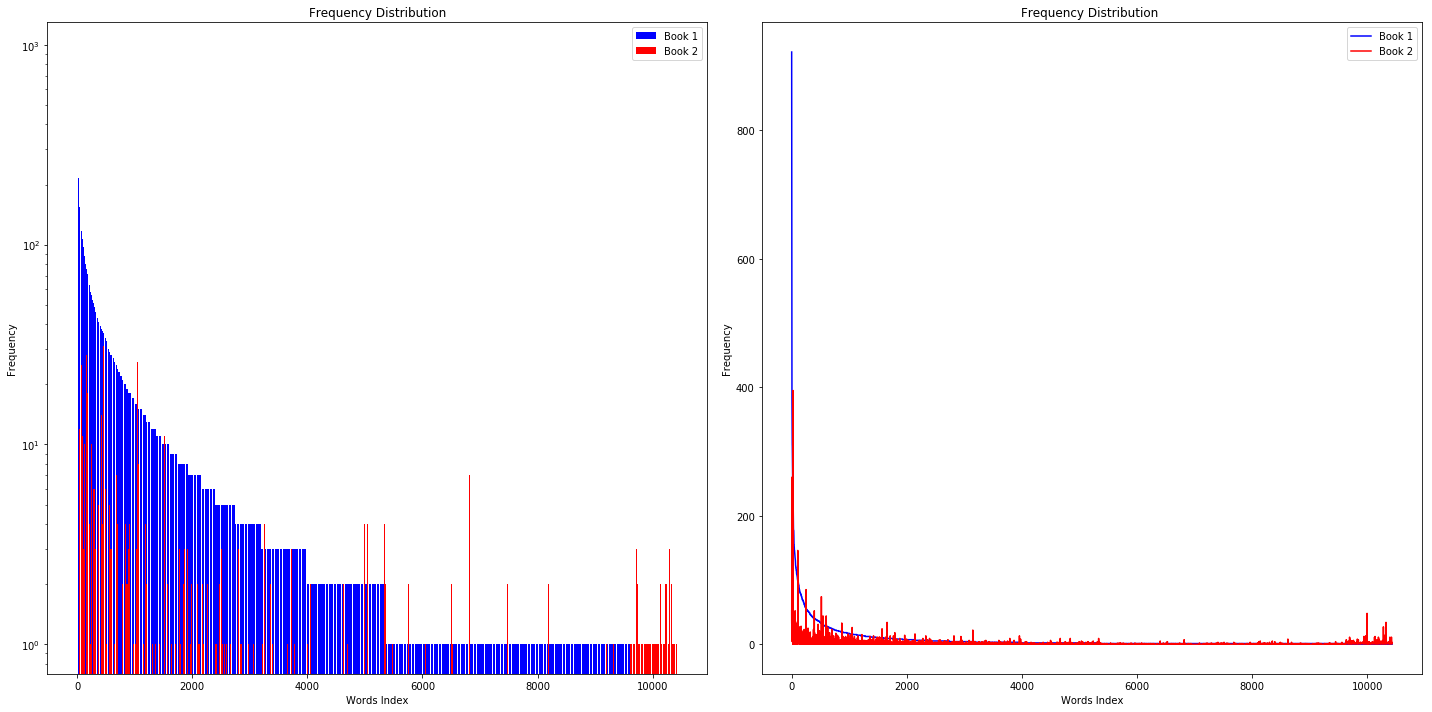

In [27]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,10))

ax1.bar(x_labels,book_1_freq,label = 'Book 1',color = 'b')
ax1.bar(x_labels,book_2_freq,label = 'Book 2',color = 'r')
ax1.legend(loc = 'upper right')
ax1.set_xlabel('Words Index')
ax1.set_ylabel('Frequency')
ax1.set_title('Frequency Distribution')
ax1.set_yscale('log')


ax2.plot(x_labels,book_1_freq,label = 'Book 1',color = 'b')
ax2.plot(x_labels,book_2_freq,label = 'Book 2',color = 'r')
ax2.legend(loc = 'upper right')
ax2.set_xlabel('Words Index')
ax2.set_ylabel('Frequency')
ax2.set_title('Frequency Distribution ')


plt.tight_layout()
plt.show()

Now below we plot the top 15 frequent words from each book. 

In [28]:
most_freq_b1 = freq_df.sort("Book1",ascending = False).limit(15).collect()
x_lab_b1 = [each_row["word"] for each_row in most_freq_b1]
freq_b1 = [each_row["Book1"] for each_row in most_freq_b1]


In [29]:
most_freq_b2 = freq_df.sort("Book2",ascending = False).limit(15).collect()
x_lab_b2 = [each_row["word"] for each_row in most_freq_b2]
freq_b2 = [each_row["Book2"] for each_row in most_freq_b2]

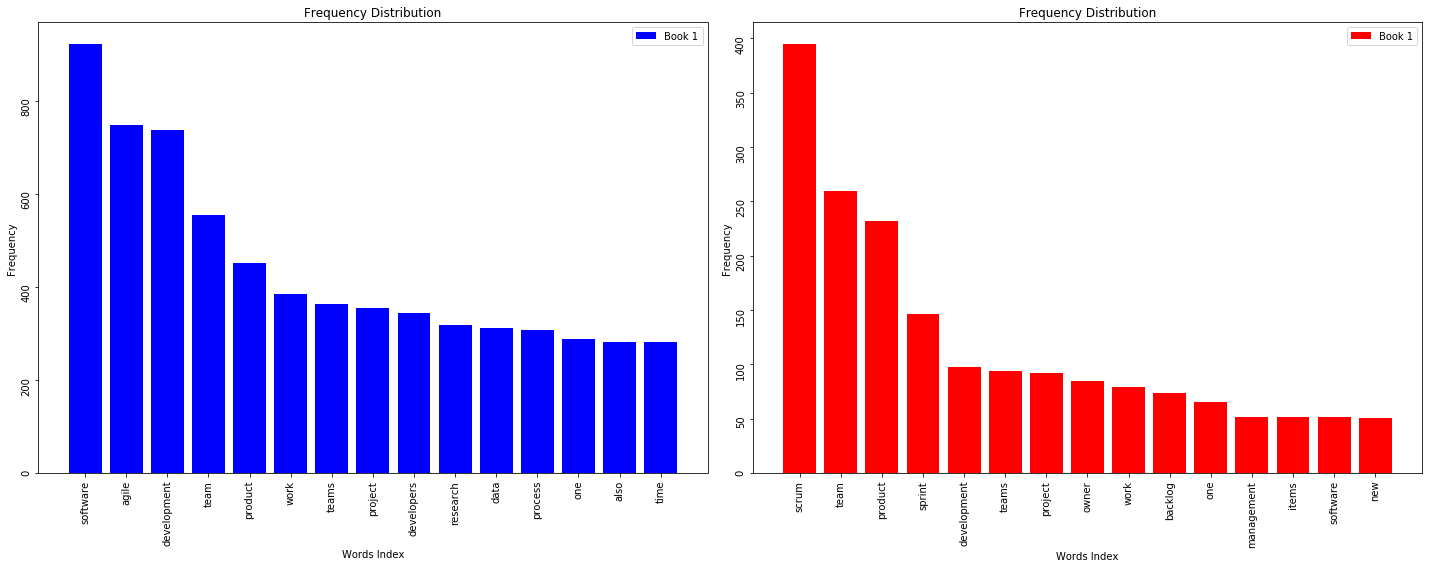

In [30]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,8))

ax1.bar(x_lab_b1,freq_b1,label = 'Book 1',color = 'b')
ax1.legend(loc = 'upper right')
ax1.set_xlabel('Words Index')
ax1.set_ylabel('Frequency')
ax1.set_title('Frequency Distribution')
ax1.tick_params(labelrotation=90)

ax2.bar(x_lab_b2,freq_b2,label = 'Book 1',color = 'r')
ax2.legend(loc = 'upper right')
ax2.set_xlabel('Words Index')
ax2.set_ylabel('Frequency')
ax2.set_title('Frequency Distribution')
ax2.tick_params(labelrotation=90)
plt.tight_layout()
plt.show()

From the plot above we can see that almost half of the words that made to the most freqent words for book 1 also made it to book 2. In total out of 15, both of the books share 8 words i most freqent word list, the freqent words being `software`, `development`, `team`, `teams`, `product`, `work`, `project` & `one`.

If we closely look at the words we find that these words are core of agile methodology and hence they made it to the most freqent word list in both the books.
